In [1]:
import numpy as np
import sys
import time
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm')

%load_ext autoreload
%autoreload 2

In [2]:
from word2vec_eltdm.word2vec_numpy import (
    Tokenizer, VocabCreator, DataLoader, TokenCleaner, Preprocessor,
    Subsampler, SimpleWord2Vec, Optimizer, CrossEntropy, train, validate, NegWord2Vec,
    NegativeSamplingLoss, OptimizeNSL
)

## Get data and create vocab

In [3]:
datapath = "../data/text8.txt"

RATIO = 0.10
tokenizer = Tokenizer(datapath)
token_cleaner = TokenCleaner(freq_threshold=5)
vocab_creator = VocabCreator()
text8_dataset = Preprocessor(tokenizer, token_cleaner, vocab_creator, RATIO).preprocess()

In [4]:
print("Size of our vocabulary:", len(text8_dataset.tokens_to_id))

Size of our vocabulary: 16778


In [5]:
print("Number of tokens in our train dataset:", len(text8_dataset.train_tokens))

Number of tokens in our train dataset: 794731


In [6]:
print("Number of tokens in our val dataset:", len(text8_dataset.val_tokens))

Number of tokens in our val dataset: 99341


In [7]:
print("Number of tokens in our test dataset:", len(text8_dataset.test_tokens))

Number of tokens in our test dataset: 99342


## Subsampling of frequent words, as in Mikolov 2013.

In [8]:
subsampler = Subsampler(text8_dataset.train_tokens)
text8_dataset.train_tokens, text8_dataset.frequencies = subsampler.subsample()

In [9]:
print("Size of our vocabulary after subsampling of frequent words, for train:", len(text8_dataset.tokens_to_id))

Size of our vocabulary after subsampling of frequent words, for train: 16778


In [10]:
print("Number of tokens in train dataset:", len(text8_dataset.train_tokens))

Number of tokens in train dataset: 228859


## DataLoader

In [11]:
window = 5
batch_size = 256
train_dataloader = DataLoader(text8_dataset, text8_dataset.train_tokens, window, batch_size)
val_dataloader = DataLoader(text8_dataset, text8_dataset.val_tokens, window, batch_size)
test_dataloader = DataLoader(text8_dataset, text8_dataset.test_tokens, window, batch_size)

In [12]:
start = time.perf_counter()
for batch in tqdm(train_dataloader):
    X, y = batch["X"], batch["Y"]
end = time.perf_counter()
print(f"Lopped through all the training dataset in {end - start:0.4f} seconds")

  0%|          | 0/893 [00:00<?, ?it/s]

Lopped through all the training dataset in 0.6806 seconds


## Model

In [13]:
# defining the parameters
len_vocab = len(text8_dataset.tokens_to_id)
hidden_size = 500
embedding_size = 300
learning_rate = 1e-3
n_samples = 5

# Get our noise distribution
word_freqs = np.array(sorted(text8_dataset.frequencies.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75))

# instantiate the model
model = NegWord2Vec(
    len_vocab,
    hidden_size,
    embedding_size,
    noise_dist=noise_dist
)
model.initialize_weights()
#model.initialize_embeddings()

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = OptimizeNSL(model,learning_rate)

## Training

In [14]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer):
    train_loss = 0.0
    for i, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        X, y = batch["X"], batch["Y"]
        h = model.forward_input(X)
        u = model.forward_output(y)
        noise_vector = model.forward_noise(X.shape[1], n_samples)

        # negative sampling loss
        loss, grad_W1, grad_W2 = criterion(model, h, u, noise_vector, y)
        optimizer.step(grad_W1, grad_W2)

        train_loss += loss

        if i % 1500 == 0:
            print(
                "Current Training Loss {:.6}".format(loss)
            )
            validation_loss = validate(model, val_dataloader, criterion)

    train_loss /= len(train_dataloader)
    return train_loss, validation_loss


def update_best_loss(model, val_loss):
    # Update the model and best loss if we see improvements.
    if not model.best_val_loss or val_loss < model.best_val_loss:
        model.best_val_loss = val_loss
        model.best_W1 = model.W1
        model.best_W2 = model.W2


def validate(model, dataloader, criterion):
    model.eval()
    validation_loss = 0
    for i, batch in enumerate(tqdm(dataloader)):
        X, y = batch["X"], batch["Y"]
        h = model.forward_input(X)
        u = model.forward_output(y)
        noise_vector = model.forward_noise(X.shape[1], n_samples)
        
        loss, grad_W1, grad_W2 = criterion(model, h, u, noise_vector, y)
        validation_loss += loss

        # if i % 1500 == 0:
        #     print(
        #         "Current Validation Loss {:.6}".format(loss)
        #     )

    validation_loss /= len(dataloader)

    # Keep track of the best model
    update_best_loss(model, validation_loss)

    print("Validation Loss: ", validation_loss)

    return validation_loss

In [15]:
# train for some number of epochs
epochs = 5
train_loss_history = []
val_loss_history = []
tbar = trange(epochs)
for epoch in tbar:
    print(f"###################### EPOCH {epoch} ###########################")
    train_loss, val_loss= train(model, train_dataloader, val_dataloader, criterion, optimizer)
    print("Training loss:", train_loss)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    #if epoch % 2 == 0:
    #    validation_loss = validate(model, val_dataloader, criterion)
    #    print("Validation loss:", validation_loss)
    #    val_loss_history.append(validation_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

###################### EPOCH 0 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 14.5648


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  15.253551410610445
Training loss: 14.499240828639731
###################### EPOCH 1 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 14.4249


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  14.888767824015988
Training loss: 14.395076375373991
###################### EPOCH 2 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 14.0669


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  14.55287760273875
Training loss: 14.26582543234625
###################### EPOCH 3 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 14.2133


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  14.24098632609223
Training loss: 14.166285756551035
###################### EPOCH 4 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 13.9496


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  13.942330017571699
Training loss: 14.05913135153047


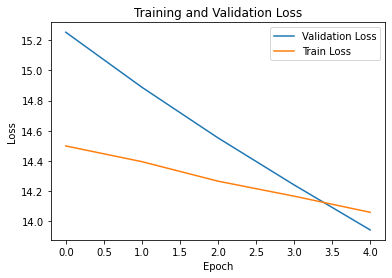

In [16]:
plt.plot(val_loss_history, label = "Validation Loss")
plt.plot(train_loss_history, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() 
plt.title('Training and Validation Loss')
plt.show() 

In [17]:
print(model.best_W1)

[[ 0.23096148 -0.10524724  0.20794907 ... -0.5780272  -0.27285562
   0.07106665]
 [ 0.09568512  0.47566895  0.75126512 ...  0.37121963 -0.72985339
  -0.30290041]
 [-0.78775872 -0.00625934 -0.44749784 ...  0.52926533  0.02438837
   0.38923102]
 ...
 [ 0.35761269  0.8777713  -0.63161985 ... -0.20375189 -0.59099952
   0.40087525]
 [-0.54813405 -0.2124124  -0.00622124 ...  0.42051645  0.36544361
  -0.59061118]
 [-0.6123491  -0.27846747  0.18691454 ... -0.33647415 -0.99920775
   0.29527826]]


In [18]:
print(model.best_W2)

[[ 0.23147396 -0.10563771  0.20842087 ... -0.57860755 -0.27243601
   0.07067455]
 [ 0.09520094  0.47622864  0.75183196 ...  0.37104424 -0.72980873
  -0.30281792]
 [-0.78774835 -0.00626717 -0.44750456 ...  0.52927105  0.02438706
   0.38921975]
 ...
 [ 0.35741092  0.8779192  -0.63030227 ... -0.20226071 -0.59061563
   0.40336761]
 [-0.5483613  -0.21298009 -0.00674229 ...  0.42088978  0.36624724
  -0.59033405]
 [ 0.09320315  0.55409947 -0.53179087 ...  0.71192078  0.31746596
   0.95859947]]


## Results on test set